# Телеком &mdash; поиск клиентов с неоптимальными тарифами

## Содержание

<ul>
    <li><a href="#step_1">Введение</a></li>
    <li><a href="#step_3">Предобработка данных</a>
        <ul>
            <li><a href="#step_3_1"><code>telecom_dataset</code></a></li>
            <li><a href="#step_3_2"><code>telecom_clients</code></a></li>
            <li><a href="#step_3_3">Вывод</a></li>
        </ul></li>
    <li><a href="#step_4">Исследовательский анализ</a>
    <ul>     
        <li><a href="#step_4_1">Определение исследуемого периода</a></li>
        <li><a href="#step_4_2">Определение активных клиентов</a></li>
        <li><a href="#step_4_3">Исследование колл-центров по сфере деятельности</a></li>
        <li><a href="#step_4_4">Вывод</a></li>
    </ul></li>
    <li><a href="#step_5">Подсчёт выручки для активных клиентов</a>
    <ul>
        <li><a href="#step_5_1">Текущая выручка за весь период по всем клиентам</a></li>
        <li><a href="#step_5_2">Клиенты с неоптимальными тарифами</a></li> 
        <li><a href="#step_5_3">Как изменится выручка, если все клиенты перейдут на более выгодные тарифы</a>
                <ul><li><a href="#step_5_3_1">Общая</a></li>
                    <li><a href="#step_5_3_2">По месяцам</a></li> 
                    <li><a href="#step_5_3_3">На одного клиента</a></li></ul></li>
        <li><a href="#step_5_4">Распределение тарифов внутри категорий до и после перехода на более выгодные варианты</a></li>
        <li><a href="#step_5_5">Выводы</a></li>
    </ul></li>
    <li><a href="#step_6">Проверка статистических гипотез</a>
    <ul><li><a href="#step_6_1">Гипотеза 1. Среднемесячные чеки активных клиентов на тарифе А выше, чем среднемесячные чеки активных клиентов на тарифе B</a></li>
        <li><a href="#step_6_2">Гипотеза 2. Среднемесячный перерасход минут активных клиентов на тарифе А равен среднемесячному перерасходу минут активных клиентов на тарифе B</a></li> </ul></li>
</ul>

<a id='step_1'></a>
## Введение

**Краткое описание исследования**: требуется провести исследование датасетов, предоставленных провайдером виртуальной телефонии &laquo;Нупозвони&raquo;. Его клиенты &mdash; колл-центры, которые: 
- распределяют входящие вызовы на операторов;  
- совершают исходящие вызовы силами операторов.  
Также операторы могут производить вызовы внутри сети.  

**Цели исследования**: неверно выбранные клиентами тарифы могут привести к оттоку клиентов/дать конкурентам преимущества в предложении более выгодных условий.  
1. Найти клиентов, которые переплачивают на текущих тарифах; 
2. Исследовать изменение в выручке при смене тарифа и определить, каким клиентам выгоден тот или иной тариф;
3. Дать рекомендации отделу по работе с клиентами.


| Тарифный план | Ежемесячная плата | Входящие | Исходящие звонки внутри сети | Лимит минут на внутренние исходящие вызовы | Исходящие звонки, кроме внутренних |Ежемесячная плата за одного оператора |
|:----------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| A | 4000 &#8381; | 0 | 0.10 &#8381;/мин | 2000 минут | 0.30 &#8381;/мин | 50 &#8381;|
| B | 2000 &#8381; | 0 | 0.15 &#8381;/мин | 500 минут | 0.50 &#8381;/мин | 150 &#8381;|
| C | 1000 &#8381; | 0 | 0.30 &#8381;/мин | 0 минут | 0.70 &#8381;/мин | 300 &#8381; |

<a id='step_2'></a>
## Предобработка данных
Импортируем все библиотеки, необходимые для выполнения исследования:

In [421]:
import pandas as pd
import datetime as dt
from datetime import date
from datetime import timezone
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import numpy as np
from scipy import stats as st
import itertools

import warnings
warnings.filterwarnings('ignore')

Перенесём информацию о тарифах в датафрейм `tariffs`:

In [422]:
tariffs = pd.DataFrame({'name': ['A', 'B', 'C'], 
                        'subscription_fee': [4000, 2000, 1000],
                        'income_cost': [0, 0, 0],
                        'outgoing_internal_cost_per_min': [0.10, 0.15, 0.30],
                        'outgoing_internal_minutes_limit': [2000, 500, 0],
                        'outgoing_external_cost_per_min': [0.30, 0.50, 0.70],
                        'payment_per_operator': [50, 150, 300]})
tariffs = tariffs.set_index('name')
tariffs

,subscription_fee,income_cost,outgoing_internal_cost_per_min,outgoing_internal_minutes_limit,outgoing_external_cost_per_min,payment_per_operator
name,,,,,,
A,4000,0,0.10,2000,0.3,50
B,2000,0,0.15,500,0.5,150
C,1000,0,0.30,0,0.7,300


<a id='step_2_1'></a>
### telecom_dataset

In [423]:
try:
    data = pd.read_csv('/datasets/telecom_dataset.csv')
except:
    data = pd.read_csv('https:/datasets/telecom_dataset.csv')
display(data.head())
data.info()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


Исследуем датасет на наличие явных дубликатов:

In [424]:
print("Количество строк-дубликатов:", data.duplicated().sum()) 
print("Доля дубликатов в датафрейме:", round(data.duplicated().sum()/data.shape[0]*100,2),"%")

Количество строк-дубликатов: 4900
Доля дубликатов в датафрейме: 9.09 %


Так как данные уже агрегированы по клиентам, датам и типам звонков, явных дубликатов в датасете быть не должно. Удалим их: 

In [425]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              49002 non-null  int64  
 1   date                 49002 non-null  object 
 2   direction            49002 non-null  object 
 3   internal             48892 non-null  object 
 4   operator_id          41546 non-null  float64
 5   is_missed_call       49002 non-null  bool   
 6   calls_count          49002 non-null  int64  
 7   call_duration        49002 non-null  int64  
 8   total_call_duration  49002 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.4+ MB


Проверим данные на наличие неявных дубликатов:

In [426]:
print("Количество строк-дубликатов:",data.duplicated(subset=['user_id', 'date', 'direction', 'internal', 'operator_id','is_missed_call']).sum())

Количество строк-дубликатов: 0


Проверим столбцы `direction` и `internal` на наличие неявных дубликатов:

In [427]:
print("Уникальные значения в столбце direction:",data['direction'].unique())
print("Уникальные значения в столбце internal:",data['internal'].unique())

Уникальные значения в столбце direction: ['in' 'out']
Уникальные значения в столбце internal: [False True nan]


В столбцах `direction` и `internal` нет неявных дубликатов.

Некорректный тип данных у столбцов `date` (`object` -> `datetime`), `internal` (`object` - > `bool`) и `operator_id` (`float64` -> `int64`). Проверим, какие значения хранятся в столбце `date`.

In [428]:
sorted(data['date'].unique())

['2019-08-02 00:00:00+03:00',
 '2019-08-03 00:00:00+03:00',
 '2019-08-04 00:00:00+03:00',
 '2019-08-05 00:00:00+03:00',
 '2019-08-06 00:00:00+03:00',
 '2019-08-07 00:00:00+03:00',
 '2019-08-08 00:00:00+03:00',
 '2019-08-09 00:00:00+03:00',
 '2019-08-10 00:00:00+03:00',
 '2019-08-11 00:00:00+03:00',
 '2019-08-12 00:00:00+03:00',
 '2019-08-13 00:00:00+03:00',
 '2019-08-14 00:00:00+03:00',
 '2019-08-15 00:00:00+03:00',
 '2019-08-16 00:00:00+03:00',
 '2019-08-17 00:00:00+03:00',
 '2019-08-18 00:00:00+03:00',
 '2019-08-19 00:00:00+03:00',
 '2019-08-20 00:00:00+03:00',
 '2019-08-21 00:00:00+03:00',
 '2019-08-22 00:00:00+03:00',
 '2019-08-23 00:00:00+03:00',
 '2019-08-24 00:00:00+03:00',
 '2019-08-25 00:00:00+03:00',
 '2019-08-26 00:00:00+03:00',
 '2019-08-27 00:00:00+03:00',
 '2019-08-28 00:00:00+03:00',
 '2019-08-29 00:00:00+03:00',
 '2019-08-30 00:00:00+03:00',
 '2019-08-31 00:00:00+03:00',
 '2019-09-01 00:00:00+03:00',
 '2019-09-02 00:00:00+03:00',
 '2019-09-03 00:00:00+03:00',
 '2019-09-

В датафрейме представлены данные c указанием временной зоны UTC+3. Так как данные агрегированы по дням, представим данные в столбце в формте `yyyy-mm-dd`.


In [429]:
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.tz_localize(None)
display(data.head())
data.info()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
1,166377,2019-08-05,out,True,880022.0,True,3,0,5
2,166377,2019-08-05,out,True,880020.0,True,1,0,1
3,166377,2019-08-05,out,True,880020.0,False,1,10,18
4,166377,2019-08-05,out,False,880022.0,True,3,0,25


<class 'pandas.core.frame.DataFrame'>
Index: 49002 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              49002 non-null  int64         
 1   date                 49002 non-null  datetime64[ns]
 2   direction            49002 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41546 non-null  float64       
 5   is_missed_call       49002 non-null  bool          
 6   calls_count          49002 non-null  int64         
 7   call_duration        49002 non-null  int64         
 8   total_call_duration  49002 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.4+ MB


Для корректировки типа данных в столбце `internal` необходимо обработать пропущенные значения, которые в нём содержатся. 

In [430]:
pd.DataFrame(round(data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
date,0.000000
direction,0.000000
internal,0.200000
operator_id,15.200000
is_missed_call,0.000000
calls_count,0.000000
call_duration,0.000000
total_call_duration,0.000000


Доля пропущенных значений в столбце `internal` составляет 0.2%. Проверим, есть ли у строк с пропусками что-то общее:

In [431]:
internal_na = data.query('internal.isna()')
internal_na

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
1007,166405,2019-09-18,in,NaN,NaN,True,1,0,59
1090,166405,2019-10-01,in,NaN,NaN,True,1,0,1
1864,166406,2019-08-20,in,NaN,NaN,True,1,0,36
1924,166406,2019-09-02,in,NaN,879898.0,False,1,2,9
6210,166541,2019-09-26,in,NaN,908960.0,False,1,393,423
...,...,...,...,...,...,...,...,...,...
52462,168361,2019-11-09,in,NaN,NaN,True,6,0,14
52590,168361,2019-11-13,in,NaN,NaN,True,2,0,6
52621,168361,2019-11-14,in,NaN,NaN,True,1,0,2
53717,168579,2019-11-09,in,NaN,NaN,True,1,0,18


In [432]:
data.query('operator_id.isna()').pivot_table(index=['direction'],
                                             columns=['is_missed_call'],
                                             aggfunc='size')

is_missed_call,False,True
direction,,
in,68,7202
out,45,141


Большая часть таких событий &mdash; это входящие вызовы, они бесплатны для клиента. 

In [433]:
data.query('internal.isna() & direction=="out"')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
21004,167016,2019-10-23,out,NaN,NaN,True,3,0,196
51367,168291,2019-11-28,out,NaN,NaN,True,3,0,93


Возможно, в системе случались кратковременные сбои, из-за которых ВАТС не могла установить источник вызова. Без этой информации не сможем корректно рассчитать стоимость звонков, но, так как таких строчек мало, &mdash; удалим их из датафрейма.

In [434]:
data = data.dropna(subset=['internal'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48892 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              48892 non-null  int64         
 1   date                 48892 non-null  datetime64[ns]
 2   direction            48892 non-null  object        
 3   internal             48892 non-null  object        
 4   operator_id          41491 non-null  float64       
 5   is_missed_call       48892 non-null  bool          
 6   calls_count          48892 non-null  int64         
 7   call_duration        48892 non-null  int64         
 8   total_call_duration  48892 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 3.4+ MB


Корректировка типа данных в столбце `operator_id` невозможна, пока в нём присутствуют пропущенные значения. Исследуем их:

In [435]:
data.query('operator_id.isna()')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04,in,False,NaN,True,2,0,4
7,166377,2019-08-05,in,False,NaN,True,6,0,35
9,166377,2019-08-06,in,False,NaN,True,4,0,62
17,166377,2019-08-07,in,False,NaN,True,2,0,24
27,166377,2019-08-12,in,False,NaN,True,2,0,34
...,...,...,...,...,...,...,...,...,...
53876,168601,2019-11-27,in,False,NaN,True,2,0,39
53880,168601,2019-11-28,in,False,NaN,True,1,0,19
53889,168603,2019-11-28,in,False,NaN,True,1,0,30
53893,168606,2019-11-08,in,False,NaN,True,6,0,121


In [436]:
data.query('operator_id.isna()').pivot_table(index=['direction','is_missed_call'],
                                             columns=['internal'],
                                             aggfunc='size')

internal                  False  True 
direction is_missed_call              
in        False              62      6
          True             6870    279
out       False              38      7
          True              108     31

Пропуск в графе `operator_id` чаще всего встречается среди входящих внешних пропущенных вызовов: скорее всего, во время поступления звонка все операторы были заняты и никто не смог ответить на звонок. Входящие, которые состоялись и на которые не был назначен оператор, мог принимать автоответчик, а исходящие могли совершаться с помощью технологии автодозвона. Строки с пропусками в этом столбце удалять не будем, так как сохранены остальные данные о звонках, по которым можно рассчитать оплату за услуги => тип данных `operator_id` оставим без изменений.

Исследуем столбцы `calls_count`, `call_duration` и `total_duration` на наличие аномалий. Построим диаграмму размаха по столбцу `total_call_duration`.

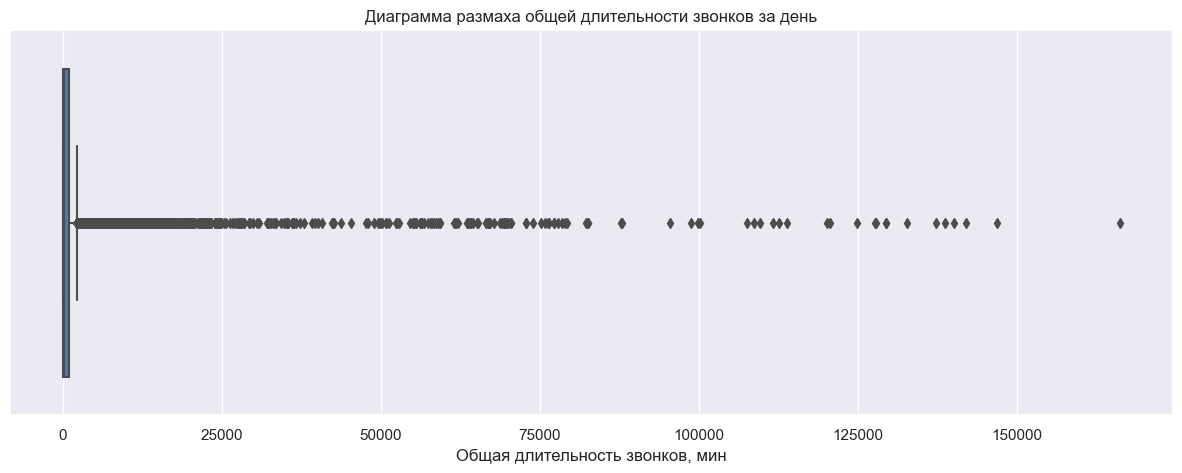

In [437]:
fig = sns.boxplot(data, x="total_call_duration")
fig.set_title('Диаграмма размаха общей длительности звонков за день')
fig.set_xlabel('Общая длительность звонков, мин')
sns.set_theme(rc={'figure.figsize':(15,3)});

Некоторые операторы были на линии более 100 000 минут в день. Подозрительно долго, с учётом того, что в сутках 1440 минут. Изолируем данные с выбросами для исследования:

In [438]:
data.query('total_call_duration>100000')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6745,166582,2019-09-02,out,False,885876.0,False,1018,90095,108665
6754,166582,2019-09-03,out,False,885876.0,False,1137,87700,109600
6761,166582,2019-09-04,out,False,885876.0,False,863,91813,107524
6769,166582,2019-09-05,out,False,885876.0,False,602,109032,120064
6808,166582,2019-09-09,out,False,885876.0,False,1138,121093,141930
6816,166582,2019-09-10,out,False,885876.0,False,1053,80782,100139
6825,166582,2019-09-11,out,False,885876.0,False,946,115057,132708
6833,166582,2019-09-12,out,False,885876.0,False,696,125286,138643
6844,166582,2019-09-13,out,False,885876.0,False,652,98748,111703
6874,166582,2019-09-17,out,False,885876.0,False,1375,100454,124787


Оператор 885876 из КЦ 166582 в сентябре почти каждый день совершал по нескольку сотен исхдящих звонков. Это наталкивает на мысль, что **несколько человек пользуются одним аккаунтом оператора для экономии**, поэтому звонков так много. Проверим колл-центр 166582:

In [439]:
operators_166582 = data.query('user_id==166582 and ~operator_id.isna()')['operator_id'].unique()
print('Операторы колл-центра 166582:', operators_166582)
data.query('operator_id in @operators_166582')

Операторы колл-центра 166582: [885890. 885876. 925922.]


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6569,166582,2019-08-12,out,False,885890.0,False,181,18953,22349
6570,166582,2019-08-12,out,False,885876.0,False,184,20746,24152
6571,166582,2019-08-12,out,False,885876.0,True,219,0,5687
6572,166582,2019-08-12,in,False,885876.0,False,9,387,473
6573,166582,2019-08-12,out,False,885890.0,True,113,0,3691
...,...,...,...,...,...,...,...,...,...
7355,166582,2019-11-26,out,False,885876.0,False,79,6926,8361
7356,166582,2019-11-27,out,False,885876.0,False,35,6811,7334
7358,166582,2019-11-27,out,False,885876.0,True,21,0,776
7360,166582,2019-11-28,out,False,885876.0,False,34,5357,5973


Колл-центр делает много продолжительных внешних исходящих вызовов, и, чтобы сэкономить на оплате услуг, выдаёт физическим операторам доступ на один из трёх аккаунтов. Отсеим даннные клиента 166582 и перестроим диаграмму размаха:

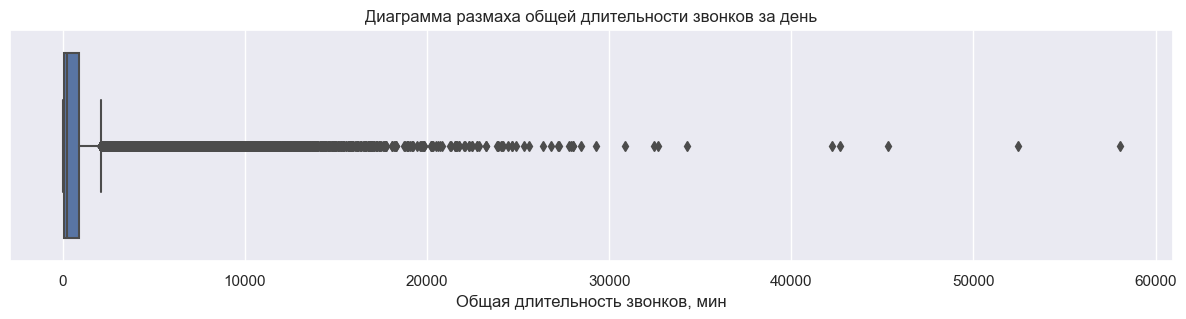

In [440]:
no_trojans = data.query('user_id!=166582')

fig = sns.boxplot(no_trojans, x="total_call_duration")
fig.set_title('Диаграмма размаха общей длительности звонков за день')
fig.set_xlabel('Общая длительность звонков, мин')
sns.set_theme(rc={'figure.figsize':(15,3)});

Колл-центр 166582 не единственный скрывает реальное количество операторов. Большая часть таких выбросов &mdash; это исходящие внешние вызовы. Предполагаю, что это колл-центры, которые специализируются на массовых обзвонах клиентов (проводят соц. опросы/рекламируют продукцию). Отфильтруем данные по внешним исходящим вызовам и рассчитаем среднее количество звонков, обрабатываемых одним оператором. 

In [441]:
find_trojans = data.query('~operator_id.isna() and direction=="out" and internal==False').pivot_table(index=['user_id','date'], values=['operator_id','calls_count'], aggfunc={'operator_id':'nunique','calls_count':'sum'})
find_trojans['calls_per_operator'] = find_trojans['calls_count']/find_trojans['operator_id']
display(find_trojans.sort_values(by='calls_per_operator', ascending=False))

calls_count  operator_id  calls_per_operator
user_id date                                                    
167827  2019-11-11         5067            2              2533.5
166582  2019-10-01         3717            2              1858.5
167285  2019-10-22         1748            1              1748.0
166582  2019-09-24         3304            2              1652.0
        2019-09-23         3291            2              1645.5
...                         ...          ...                 ...
167852  2019-11-15            1            1                 1.0
        2019-11-27            1            1                 1.0
        2019-11-28            1            1                 1.0
167888  2019-10-07            2            2                 1.0
167078  2019-11-02            1            1                 1.0

[6220 rows x 3 columns]

Построим по этой величине диаграмму размаха:

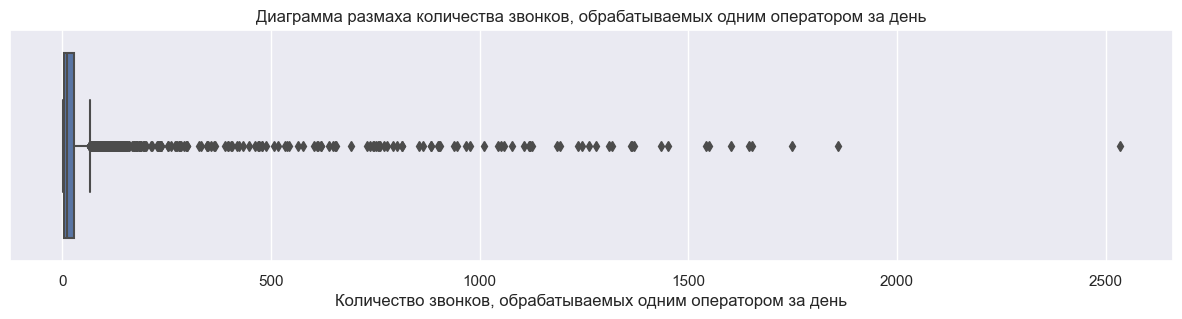

In [442]:
fig = sns.boxplot(find_trojans, x="calls_per_operator")
fig.set_title('Диаграмма размаха количества звонков, обрабатываемых одним оператором за день')
fig.set_xlabel('Количество звонков, обрабатываемых одним оператором за день')
sns.set_theme(rc={'figure.figsize':(15,3)});

Диапазон нормального распределения количества внешних звонков, совершаемых одним оператором &mdash; от 1 до 65. В зависимости от специфики вызова, время обработки звонка одним оператором может отличаться. Согласно [статье](https://ru.liveagent.com/akademija/oznovniye-pokazateli-raboty-koll-centra/), описывающей основные показатели работы колл-центра, стандартное время ответа на вызов составляет 28 секунд, а среднее время обработки вызова составляет 6 минут. Будем считать, что колл-центры работают в рамках трудового законодательства и рабочий день оператора не превышает 12 часов, а на совершение одного звонка у оператора будет уходить 5 минут. Тогда максимальное количество вызовов, совешенных за день, будет равно 144. Конечно, некоторые люди не примут звонок от незнакомого номера или завершат вызов досрочно, но и работать в одном темпе все 12 часов оператор не сможет. Выясним, в каких колл-центрах показатель среднего количества звонков, совершаемых оператором, превысит 150.

In [443]:
trojans = find_trojans.query('calls_per_operator>150').index.get_level_values(0).unique().to_list()
trojans

[166406,
 166533,
 166582,
 167112,
 167285,
 167626,
 167645,
 167650,
 167827,
 168018,
 168025,
 168064,
 168093,
 168361]

Рекомендую проверить клиентов с id 166406, 166533, 166582, 167112, 167285, 167626, 167645, 167650, 167827, 168018, 168025, 168064, 168093, 168361 на сокрытие реального количества операторов. Отфильтруем события, совершаемые клиентами из вышеуказанного списка, и перестроим диаграмму размаха по столбцу `total_call_duration`

In [444]:
no_trojans = data.query('~(user_id in @trojans) and ~operator_id.isna()')


Даже после очистки потенциальных нарушителей, на диаграмме размаха есть много выбросов. Отфильтруем данные по выбросам и подсчитаем среднюю продолжительность вызова:

In [445]:
filtered_no_trojans = no_trojans.query('total_call_duration>1440')
filtered_no_trojans['avg_call_duration'] = filtered_no_trojans['total_call_duration']/filtered_no_trojans['calls_count']
filtered_no_trojans.sort_values(by='avg_call_duration',ascending=False)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,avg_call_duration
14787,166843,2019-10-02,out,False,926312.0,False,1,3550,3609,3609.000000
8370,166658,2019-09-11,out,False,890412.0,False,2,5798,5815,2907.500000
34461,167497,2019-11-19,out,True,924946.0,False,1,2891,2904,2904.000000
8986,166658,2019-10-10,out,False,891166.0,False,1,2607,2618,2618.000000
31087,167397,2019-11-19,in,False,927142.0,False,1,2325,2329,2329.000000
...,...,...,...,...,...,...,...,...,...,...
25276,167125,2019-10-04,out,False,902744.0,True,122,0,1951,15.991803
25243,167125,2019-10-02,out,False,902744.0,True,142,0,2206,15.535211
25378,167125,2019-10-09,out,False,902778.0,True,105,0,1626,15.485714
25390,167125,2019-10-10,out,False,902744.0,True,110,0,1686,15.327273


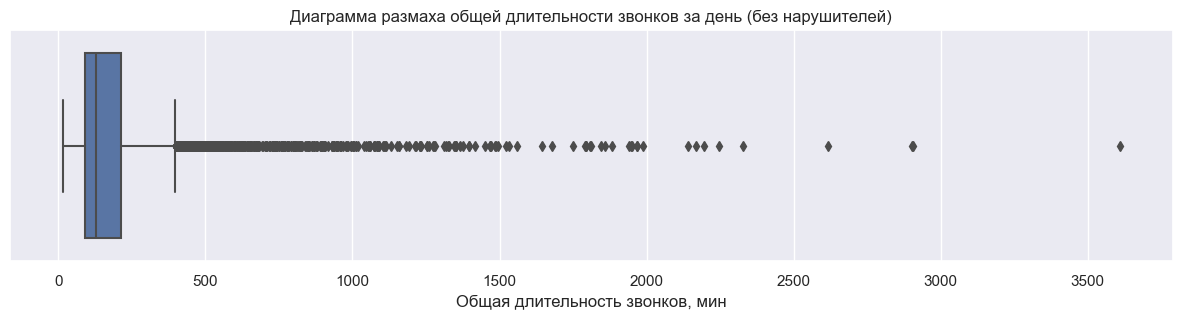

In [446]:
fig = sns.boxplot(filtered_no_trojans, x="avg_call_duration")
fig.set_title('Диаграмма размаха общей длительности звонков за день (без нарушителей)')
fig.set_xlabel('Общая длительность звонков, мин')
sns.set_theme(rc={'figure.figsize':(15,3)});

В данных есть операторы, чьи звонки длились более 60 часов. Опеределим, в какие месяцы совершались вызовы-аномалии:

In [447]:
filtered_no_trojans = filtered_no_trojans.query('avg_call_duration>720')
filtered_no_trojans['month'] = filtered_no_trojans['date'].to_numpy().astype('datetime64[M]')
filtered_no_trojans_pivot = filtered_no_trojans.pivot_table(index = 'month',values='user_id',aggfunc='count')
filtered_no_trojans_pivot

,user_id
month,
2019-08-01,15
2019-09-01,39
2019-10-01,76
2019-11-01,73


Число звонков аномалий выросло в октябре. Были ли сбои в работе оборудования в октябре и ноябре, которые фиксируются мониторингом оператора связи?

<a id='step_2_2'></a>
### telecom_clients

Исследуем общую информацию о датафрейме:

In [448]:
try:
    clients = pd.read_csv('/datasets/telecom_clients.csv', parse_dates=['date_start'])
except:
    clients = pd.read_csv('https://datasets/telecom_clients.csv', parse_dates=['date_start'])
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      732 non-null    int64         
 1   tariff_plan  732 non-null    object        
 2   date_start   732 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 17.3+ KB


В датафрейме отсутствуют пропущенные значения. Типы данных корректны для всех столбцов. Исследуем значения, хранящиеся в каждом из столбцов:

In [449]:
print("Количество строк-дубликатов:", clients.duplicated().sum()) 

Количество строк-дубликатов: 0


Явных дубликатов в датафрейме `clients` не обнаружено.

In [450]:
print('Количество уникальных клиентов:', clients['user_id'].nunique())
print('Тарифы клиентов:',clients['tariff_plan'].unique())
print('Самая ранняя дата заключения договора',clients['date_start'].min())
print('Самая поздняя дата заключения договора',clients['date_start'].max())

Количество уникальных клиентов: 732
Тарифы клиентов: ['A' 'C' 'B']
Самая ранняя дата заключения договора 2019-08-01 00:00:00
Самая поздняя дата заключения договора 2019-10-31 00:00:00


В датафрейме нет дубликатов среди идентификаторов клиентов. В столбце `tariff_plan` указаны только тарифы колл-центра. Клиенты заключали договоры с оператором с 1 августа 2019 года по 31 октября 2019 года. Проверим, нет ли таких клиентов, которые начали пользоваться услугами оператора до того, как заключили договор (например, во время триала):

In [451]:
for user in clients.index:
    min_date = data.query('user_id == @user')['date'].min()
    if min_date< clients.loc[user,'date_start']:
        clients.loc[user,'conflict']=True
    else:    
        clients.loc[user,'conflict']=False
        
clients    


,user_id,tariff_plan,date_start,conflict
0,166713,A,2019-08-15,False
1,166901,A,2019-08-23,False
2,168527,A,2019-10-29,False
3,167097,A,2019-09-01,False
4,168193,A,2019-10-16,False
...,...,...,...,...
727,166554,B,2019-08-08,False
728,166911,B,2019-08-23,False
729,167012,B,2019-08-28,False
730,166867,B,2019-08-22,False


In [452]:
clients['conflict'].unique()

array([False], dtype=object)

В датафрейме нет клиентов, которые начали пользоваться услугами до момента заключения договора.

Проверим, что в датафрейме `clients` есть информация обо всех пользователях совершавших действия в системе с августа по ноябрь 2019 года:

In [453]:
users_in_data = data['user_id'].unique()
users_in_clients = clients['user_id']
if set(users_in_data).issubset(users_in_clients):
    print('Есть информация по тарифам для всех пользователей из предоставленных логов')
else:
    
    print('Информация о пользователях неполная')

Есть информация по тарифам для всех пользователей из предоставленных логов


Для всех клиентов, обрабатывающих звонки с августа по ноябрь 2019 года есть информация об используемом тарифе.

<a id='step_2_3'></a>
### Выводы

1. В датафрейме, содержащем агрегированные данные о звонках (`data`), был обнаружен высокий процент строк-дубликатов (~9%). Отделу, подготовившему выгрузку, рекомендую перепроверить алгоритм выгрузки данных для определения причины появления дубликатов в выгрузке.
2. Данные о звонках собирались со 2 августа по 28 ноября 2019 года. 
3. Было обнаружено небольшое количество пропущенных значений в столбце `internal`: большая часть из них &mdash; пропущенные входящие вызовы, которые не тарифицируются. Так как пропусков малое количество и восстановлению они не подлежат, из датафрейма они удалены.
4. Также обнаружено большое количество пропущенных значений в столбце `operator_id`, большая часть из них &mdash; пропущенные входящие вызовы. 
5. В датафрейме обнаружилось большое количество аномально долгих звонков (которые длились больше суток), большая часть из них произошла в октябре и ноябре 2019 года. Рекомендую перепроверить данные мониторинга оператора связи на наличие сбоев в работе оборудования и связаться с КЦ для уточнения деталей.
6. Также обнаружены несколько клиентов, которых можно заподозрить в сокрытии реального количества операторов: 166406, 166533, 166582, 167112, 167285, 167626, 167645, 167650, 167827, 168018, 168025, 168064, 168093, 168361. Рекомендую службе безопасности операторов перепроверить клиентов с вышеперечисленными идентификаторами.
7. В датафрейме, содержащем информарцию о клиентах (`clients`), не было обнаружено пропущенных и аномальных значений. Договоры заключались с 1 августа по 31 октября 2019 года, всего 732 клиента в базе. 

<a id='step_3'></a>
## Исследовательский анализ данных

Построим гистограмму распределения клиентов по дате заключения договора:

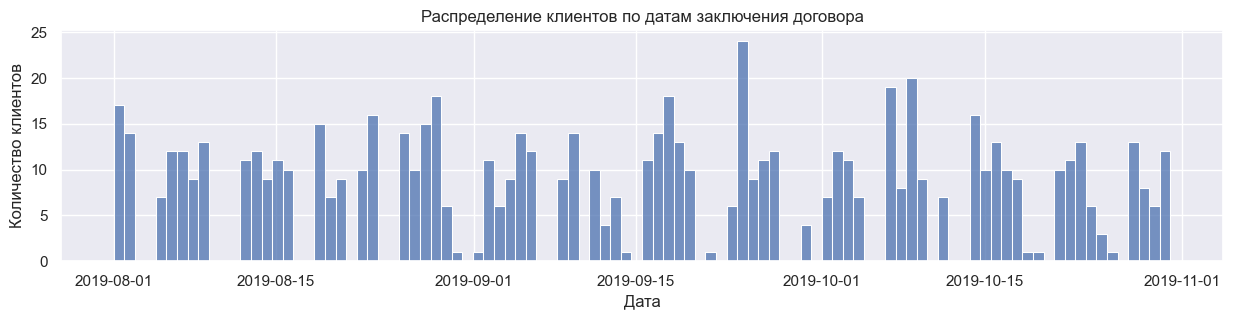

In [454]:
sns.histplot(data=clients, x="date_start", bins=100)
plt.title('Распределение клиентов по датам заключения договора')
plt.xlabel('Дата')
plt.ylabel('Количество клиентов')
plt.show()


На гистограмме хорошо видна периодичность 5/2 &mdash; в выходные клиенты реже заключают договоры на оказание услуг. Динамики на рост или спад не выявлено &mdash; почти каждый день заключалось от 10-15 договоров с новыми клиентами. Количество пользователей росло в арифметической прогрессии. 

<a id='step_3_1'></a>
### Определение исследуемого периода

Построим гистограмму распределения событий в колл-центрах по дням:

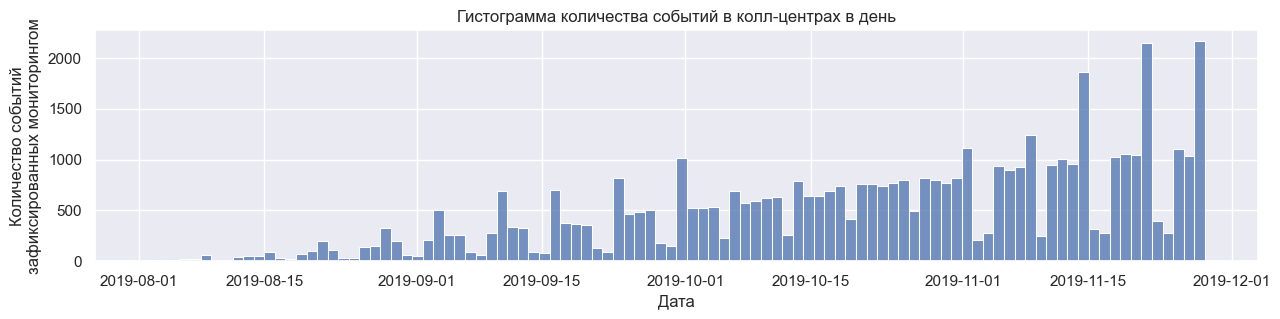

In [455]:
sns.histplot(data=data, x="date", bins=100)
sns.set_theme(rc={'figure.figsize':(15,5)});
plt.title('Гистограмма количества событий в колл-центрах в день')
plt.xlabel('Дата')
plt.ylabel('Количество событий\nзафиксированных мониторингом')
plt.show()

Так же, как и на предыдущей гистограмме, хорошо заметны циклы 5/2 &mdash; многие клиенты не обрабатывают звонки в выходные дни. С ростом количества клиентов росло и количество событий в мониторинге оператора. Подсчитаем количество событий по месяцам:

In [456]:
data['month']  = data['date'].to_numpy().astype('datetime64[M]')
statistics_pivot = data.pivot_table(index='month',values='user_id',aggfunc='count')
statistics_pivot['user_id']=statistics_pivot['user_id']/statistics_pivot['user_id'].sum()
statistics_pivot.columns = ['share']
statistics_pivot

,share
month,
2019-08-01,0.038002
2019-09-01,0.171419
2019-10-01,0.350691
2019-11-01,0.439888


В августе произошло лишь 4% от общего объема предоставленных данных &mdash; этих данных мало, чтобы сделать по ним справедливые выводы относительно динамики выручки. Отфильтруем все события, произошедшие в августе:

In [457]:
data = data.query('date>="2019-09-01"')

<a id='step_3_2'></a>
### Определение активных клиентов

Критерий неактивности: клиент не пользовался услугами оператора в течение последнего месяца.

In [458]:
#функция для оперделения неактивного клиента
def detect_active(row):
    if row['date']<data['month'].max():
        return False
    else: 
        return True

In [459]:
#создание сводной таблицы в которой хранится id пользователя и дата последнего события    
active = data.pivot_table(index='user_id', values='date', aggfunc="max").reset_index()
#применям функцию для разметки активных/неактивных клиентов
active['is_active'] = active.apply(detect_active, axis=1)

#получаем список активных клиентов
active_clients = active.query('is_active==True')['user_id'].unique()
print('Общее количество клиентов, совершавших действия в период наблюдений:', data['user_id'].unique().size)
print('Количество активных клиентов:', active_clients.size)

Общее количество клиентов, совершавших действия в период наблюдений: 303
Количество активных клиентов: 261


<a id='step_3_3'></a>
### Исследование колл-центров по сфере деятельности

Поделим клиентов на 4 типа: 
- входящие колл-центры (количество входящих вызовов>>количество исходящих вызовов);
- исходящие колл-центры (количество входящих вызовов<<количество исходящих вызвов);
- смешанные колл-центры (количество входящих вызовов ≈ количество исходящих вызвов);
- связь в офисе (кол-во внутренних вызовов >> количество внешних вызовов).

In [460]:
active = data.query('user_id in @active_clients')
categorys_pivot = active.pivot_table(index=['user_id','direction'], 
                                      columns='internal',
                                      values='calls_count', 
                                      aggfunc='sum',
                                      fill_value=0)
categorys_pivot

internal           False  True 
user_id direction              
166377  in           150      0
        out         3986     36
166391  in             9      0
166392  in           177      1
166405  in          6956      0
...                  ...    ...
168601  out          586      1
168603  in             1      0
        out           14      0
168606  in            11      0
        out            8      8

[452 rows x 2 columns]

In [461]:
categorys = pd.DataFrame()
for user in active_clients:
    try:
        out_count = categorys_pivot.loc[user,'out'].sum()
    except:
        out_count = 0
        
    try:
        in_count = categorys_pivot.loc[user,"in"].sum()
    except:
        in_count = 0
        ratio_in_out = 1000000    
    else: 
        ratio_in_out = out_count/in_count
        
    try:
        internals = categorys_pivot.loc[user][True].sum()
    except:
        internals = 0   
        
    try:
        externals = categorys_pivot.loc[user][False].sum()
    except:
        externals = 0
        ratio_ex_int = 1000000   
    else: 
        ratio_ex_int = internals/externals
     
    
    if ratio_ex_int>1:
        categorys.loc[user,'category']="связь в офисе"
    else: 
        if ratio_in_out>=1.5:
            categorys.loc[user,'category']="исходящий"
        elif ratio_in_out>=0.6 and ratio_in_out<1.5:
            categorys.loc[user,'category']="смешанный"
        else:
            categorys.loc[user,'category']="входящий"
                 
categorys = categorys.reset_index()
category_pivot = categorys.pivot_table(index='category', values='index', aggfunc='count')
category_pivot.columns = ['count']
category_pivot = category_pivot.sort_values(by='count', ascending=False)  
category_pivot = categorys.pivot_table(index='category', values='index', aggfunc='count')
category_pivot.columns = ['count']
category_pivot = category_pivot.sort_values(by='count', ascending=False) 


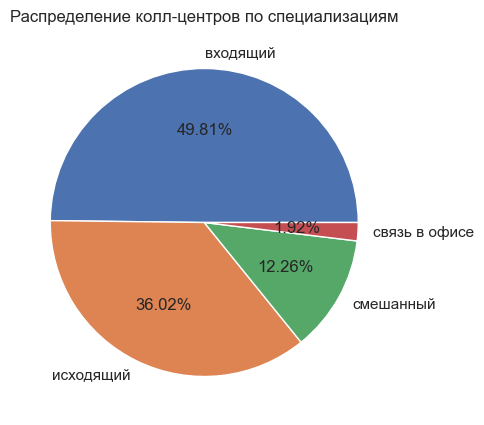

In [462]:
plt.pie(category_pivot['count'], labels=category_pivot.index, autopct='%.2f%%')
plt.title('Распределение колл-центров по специализациям');

Большая часть клиентов специализируется на обработке входящих вызовов (почти 50% из всех активных КЦ), 36% клиентов занимается обзвоном пользователей, 12.3% &mdash; обрабатывают и те, и другие вызовы, и лишь 2% пользуются услугами оператора для созвонов внутри сети. 

<a id='step_3_4'></a>
### Выводы

В ходе исследовательского анализа данных:
1. Определили исследуемый период: с 1 сентября по 30 ноября 2019 года. Данные за август отсеяли, так как за этот период было собрано слишком мало информации о звонках.
2. Определили критерий неактивности: клиент не пользовался услугами оператора в течение последнего месяца. В список активных клиентов попал 261 клиент. Также выяснили, что за время исследуемого периода 14% от всех клиентов, пользовавшихся услугами оператора связи, стали неактивными. Дополнительно исследовано распределение неактивных клиентов по последним дням активности: большая часть клиентов перестала пользоваться услугами в октябре 2019 года, при этом в октябре и ноябре было зафиксировано много аномально долгих вызовов. Возможно, слишком большие счета за услуги стали причиной прекращения сотрудничества.   
3. Разделили клиентов на 4 категории:   
    - входящие колл-центры (количество входящих вызовов >> количество исходящих вызовов);  
    - исходящие колл-центры (количество входящих вызовов << количество исходящих вызвов);  
    - смешанные колл-центры (количество входящих вызовов ≈ количество исходящих вызвов);  
    - связь в офисе (количество внутренних вызовов >> количество внешних вызовов);  
    
   Большая часть клиентов специализируется на обработке входящих вызовов (почти 50% из всех активных КЦ), 36% клиентов занимается обзвоном пользователей, 12.3% &mdash; обрабатывают и те, и другие вызовы, и лишь 2% пользуются услугами оператора для созвонов внутри сети. 

<a id='step_4'></a>
## Подсчёт выручки для активных клиентов

<a id='step_4_1'></a>
### Текущая выручка за весь период по всем клиентам

Для расчёта текущей выручки за весь период по всем клиентам воспользуемся вспомогательными функциями. Итогом расчёта станет таблица, где для каждого id пользователя будет указан тариф, средний чек и общие траты за весь период. 

In [463]:
#функция для проверки количества минут сверх пакета
def internal_limits_check(row, limit):
    """
    Возвращает series где индексы - расчётные месяцы,
    а значения - кол-во перерасходованных минут:
    - если общее кол-во минут > величины пакета тарифа (limit) - в значение записывается размер перерасхода;
    - если <= в значение записывается 0;
    - если расходов в месяце не было - возвращается 0.
    """
    result = pd.Series(dtype='float64',index = active['month'].unique())
    result = result.fillna(0)
    for index in row.index:
        if row[index] > limit:
            result[index] = row[index] - limit
        else: 
            result[index] = 0
    return result

In [464]:
#функция определения ТП клиента по таблице клиентов
def define_tariff(user):
     return clients.loc[user,'tariff_plan'] 

In [465]:
#функция расчета выручки с одного пользователя на заданном тарифе tariff_plan
def user_revenue(user, tariff_plan):
    """
    Возвращает DataFrame где индекс - id пользователя, 
    в колонках указаны расчётные месяцы,
    а значения - выручка с клиента по месяцам.
    Если клиент не был активен - в ячейку записывается NaN
    """
    #фильтрация данных по пользователю
    user_statistics = active.query('user_id==@user')
    #определяем количество операторов в колл-центре и плату за них
    operators_payment = user_statistics.pivot_table(index='user_id',
                                                    columns = 'month',
                                                    values='operator_id', 
                                                    aggfunc='nunique')
    #умножаем получившийся датафрейм на АП за оператора
    operators_payment *= tariffs.loc[tariff_plan,'payment_per_operator']
    
    #определяем количество минут на исходящие внешние вызовы
    outbounds_external = user_statistics.query('direction=="out" & internal==False')
    #считаем для пользователя кол-во минут потраченных на исходящие внешние вызовы
    outbounds_external_payment = outbounds_external.pivot_table(index='user_id', 
                                                                columns='month', 
                                                                values = 'total_call_duration', 
                                                                aggfunc='sum', 
                                                                fill_value=0)
    #если исходящих внешних звонков не было, то возвращаем 0
    if outbounds_external_payment.empty: outbounds_external_payment = 0
    #иначе умножаем датафрейм на стоимость минуты исходящего внешнего вызова    
    else: outbounds_external_payment *= tariffs.loc[tariff_plan,'outgoing_external_cost_per_min']
    
    #определяем количество минут, потраченных сверх пакета на исходящие внутренние вызовы
    outbounds_internal = user_statistics.query('direction=="out" & internal==True') 
    outbounds_internal_mins = outbounds_internal.pivot_table(index='user_id', columns='month', values = 'total_call_duration', aggfunc='sum', fill_value=0)
    if outbounds_internal.empty: outbounds_internal_payment = 0
    else:
        min_limit = tariffs.loc[tariff_plan,'outgoing_internal_minutes_limit']
        outbounds_internal_payment = internal_limits_check(outbounds_internal_mins.loc[user], min_limit)
        outbounds_internal_payment *= tariffs.loc[tariff_plan,'outgoing_internal_cost_per_min']

    payment = operators_payment+outbounds_external_payment+outbounds_internal_payment+tariffs.loc[tariff_plan,'subscription_fee']
    return payment    

In [466]:
#рассчёт выручки по массиву клиентов
def count_revenue(active_users, param):
    result = pd.DataFrame()
    tariff_s = pd.Series(dtype='object', index = active_users)
    tariff_s = tariff_s.fillna('nan')
    #если параметр == 'current' считаем выручку для каждого клиента по текущему тарифу
    if param == 'current':
        for user in active_users:
            #определяем тариф клиента
            users_tariff = define_tariff(user)
            tariff_s[user]=users_tariff
            #считаем выручку для каждого пользователя по текущему тарифу
            payment = user_revenue(user, users_tariff)
            #добавляем строчку с результатом в dataframe с результатом
            result = pd.concat([result, payment], axis=0)
            
        result.insert (0, 'tariff', tariff_s)
        #добавляем столбец с общей выручкой по всем месяцам с одного пользователя
        result['total'] = result[active['month'].unique()].sum(axis=1)  
        #добавляем столбец со среднемесячной выручкой с одного пользователя
        result['avg_month'] = round(result[active['month'].unique()].mean(axis=1),2)
    
        return result[['tariff','total','avg_month']]
    #если параметр == 'all_total' считаем гипотетическую выручку для каждого клиента по всем тарифам
    elif param == 'all_total':
        for users_tariff in tariffs.index:
            result_t = pd.DataFrame()
            for user in active_users:
                payment = user_revenue(user, users_tariff)
                result_t = pd.concat([result_t, payment], axis=0)
            result[users_tariff] = result_t[active['month'].unique()].sum(axis=1)       
        return result 
    elif param == 'all_avg_month':
        for users_tariff in tariffs.index:
            result_t = pd.DataFrame()
            for user in active_users:
                payment = user_revenue(user, users_tariff)
                result_t = pd.concat([result_t, payment], axis=0)
            result[users_tariff] = round(result_t[active['month'].unique()].mean(axis=1),2)      
        return result 
    elif param == 'best_month':
        result=pd.DataFrame()
        for user in active_users:
            users_tariff=active_users_all_tariffs_total.loc[user,'best']
            payment = user_revenue(user, users_tariff)
        result = pd.concat([result, payment], axis=0)
        return result

In [467]:
clients = clients.set_index('user_id')    
current_revenue = count_revenue(active_clients,'current')
current_revenue

,tariff,total,avg_month
user_id,,,
166377,B,158163.0,52721.00
166391,C,3600.0,1200.00
166392,C,4800.0,1600.00
166405,B,462044.2,154014.73
166406,B,142012.1,47337.37
...,...,...,...
168583,B,4450.0,2225.00
168598,C,1300.0,1300.00
168601,C,24834.4,24834.40


Выясним, как распределена выручка с активных клиентов по тарифам и как распределены клиенты по тарифам:

In [468]:
current_revenue = current_revenue.reset_index()
current_revenue_pivot = current_revenue.pivot_table(index = 'tariff',values = 'total', aggfunc = 'sum')
current_client_pivot = current_revenue.pivot_table(index = 'tariff',values = 'user_id', aggfunc = 'nunique')
current_revenue_pivot = current_revenue_pivot.sort_values(by='total', ascending=False)
current_revenue_pivot['percent'] = current_revenue_pivot['total']/current_revenue_pivot['total'].sum()*100
current_client_pivot['percent'] = current_client_pivot['user_id']/current_client_pivot['user_id'].sum()*100
current_client_pivot = current_client_pivot.sort_values(by='user_id', ascending=False)
current_revenue_pivot

,total,percent
tariff,,
A,6003453.2,37.259427
C,5862598.8,36.385238
B,4246523.2,26.355335


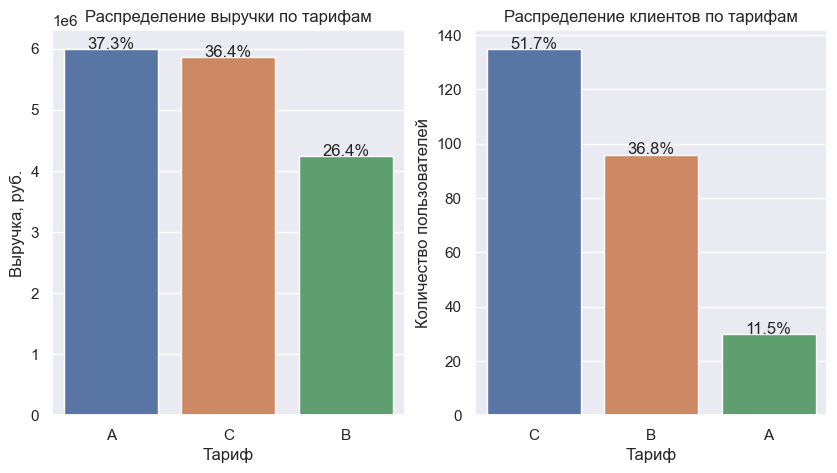

In [469]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

sns.barplot(ax=axes[0], x=current_revenue_pivot.index, y=current_revenue_pivot['total'], data=current_revenue_pivot) 
patches = axes[0].patches
ax=axes[0]
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(current_revenue_pivot['percent'][i]), (x, y), ha='center')   
axes[0].set_title('Распределение выручки по тарифам')
axes[0].set_xlabel('Тариф')
axes[0].set_ylabel('Выручка, руб.')

sns.barplot(ax=axes[1], x=current_client_pivot.index, y=current_client_pivot['user_id'], data=current_client_pivot) 

patches = axes[1].patches
ax=axes[1]
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.1f}%'.format(current_client_pivot['percent'][i]), (x, y), ha='center')
axes[1].set_title('Распределение клиентов по тарифам')
axes[1].set_xlabel('Тариф')
axes[1].set_ylabel('Количество пользователей');

51.7% клиентов пользуются тарифом С &mdash; он приносит оператору 36.4% выручки (с активных клиентов) за счёт высокой стоимости минут на исходящие внутри и вне сети, а также высокой стоимости платы за оператора. Меньше всего пользователей на тарифе A, при этом он приносит больше всего выручки компании &mdash; 37.3% от общей суммы с активных клиентов.

<a id='step_4_2'></a>
### Клиенты с неоптимальными тарифами

Рассчитаем гипотетическую среднемесячную плату для каждого пользователя по каждому из тарифов. Оптимальным будет тариф, среднемесячная плата по которому будет наименьшей.

In [470]:
def best_tarif(row):
    return row.idxmin()

In [471]:
#рассчитаем гипотетическую стоимость услуг по каждому из тарифов для всех пользователя 
active_users_all_tariffs_avg_month = count_revenue(active_clients,'all_avg_month')

active_users_all_tariffs_avg_month['best'] = active_users_all_tariffs_avg_month.apply(best_tarif, axis=1)
for user in active_users_all_tariffs_avg_month.index:
    active_users_all_tariffs_avg_month.loc[user,'current'] = define_tariff(user)
    
active_users_all_tariffs_avg_month

,A,B,C,best,current
user_id,,,,,
166377,34259.27,52721.00,72413.50,A,B
166391,4033.33,2100.00,1200.00,C,C
166392,4100.00,2300.00,1600.00,C,C
166405,94907.17,154014.73,214550.47,A,B
166406,31113.00,47337.37,64714.53,A,B
...,...,...,...,...,...
168583,4075.00,2225.00,1450.00,C,B
168598,4050.00,2150.00,1300.00,C,C
168601,14057.60,18896.00,24834.40,A,C


Будем предлагать клиенту перейти на новый тариф, если текущая переплата будет превышать 10%.

In [472]:
categorys =  categorys.set_index('index')

for user in active_users_all_tariffs_avg_month.index:
    current_t = active_users_all_tariffs_avg_month.loc[user,'current']
    best_t = active_users_all_tariffs_avg_month.loc[user,'best']
    diff = active_users_all_tariffs_avg_month.loc[user,current_t] - active_users_all_tariffs_avg_month.loc[user,best_t]
    if diff >= active_users_all_tariffs_avg_month.loc[user,current_t]*0.10:
        active_users_all_tariffs_avg_month.loc[user,'need_change'] = True
        active_users_all_tariffs_avg_month.loc[user,'save'] = diff
    else: 
        active_users_all_tariffs_avg_month.loc[user,'need_change'] = False
    active_users_all_tariffs_avg_month.loc[user,'category'] = categorys.loc[user,'category']    
        
offset = active_users_all_tariffs_avg_month.query('need_change == True')[['current','best','category']].reset_index()


offset

,user_id,current,best,category
0,166377,B,A,исходящий
1,166405,B,A,смешанный
2,166406,B,A,исходящий
3,166428,B,C,входящий
4,166485,B,A,исходящий
...,...,...,...,...
130,168578,B,C,входящий
131,168579,B,C,входящий
132,168583,B,C,входящий
133,168601,C,A,исходящий


Можно предложить 135 клиентам сменить тариф на более выгодный. Выясним, как изменится распределение клиентов по тарифам после перевода на выгодные условия:

In [473]:
for user in active_users_all_tariffs_avg_month.index:
    if user in offset['user_id']:
        active_users_all_tariffs_avg_month.loc[user,'best'] = active_users_all_tariffs_avg_month.loc[user,'current']

tariffs_distribution = active_users_all_tariffs_avg_month.reset_index()
tariffs_distribution_current = tariffs_distribution.pivot_table(index = 'current',
                                                                values = 'user_id', 
                                                                aggfunc = 'count')
tariffs_distribution_best = tariffs_distribution.pivot_table(index = 'best',
                                                                values = 'user_id', 
                                                                aggfunc = 'count')
current_client_pivot = current_revenue.pivot_table(index = 'tariff',values = 'user_id', aggfunc = 'nunique')
tariffs_distribution_best = tariffs_distribution_best.sort_values(by='user_id', ascending=False)
tariffs_distribution_current = tariffs_distribution_current.sort_values(by='user_id', ascending=False)
tariffs_distribution_current['percent'] = tariffs_distribution_current['user_id']/tariffs_distribution_current['user_id'].sum()*100
tariffs_distribution_best['percent'] = tariffs_distribution_best['user_id']/tariffs_distribution_best['user_id'].sum()*100


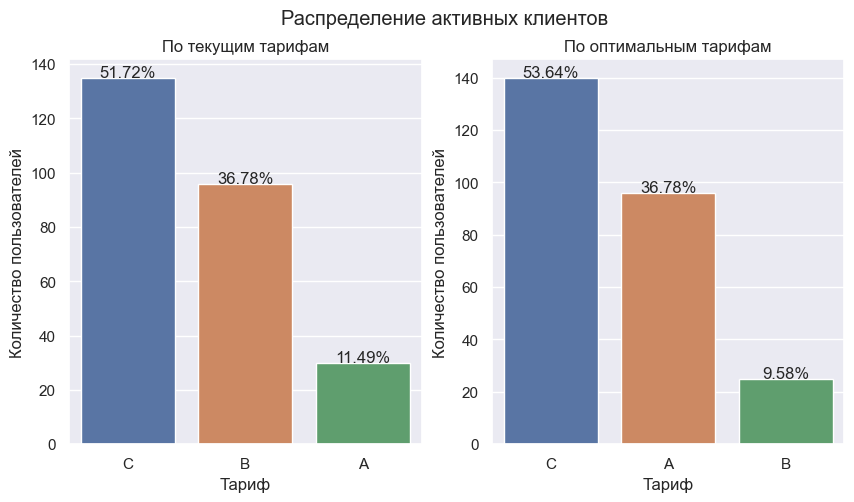

In [474]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Распределение активных клиентов')
sns.barplot(ax=axes[0], 
            x=tariffs_distribution_current.index, 
            y=tariffs_distribution_current['user_id'], 
            data=tariffs_distribution_current) 
patches = axes[0].patches
ax=axes[0]
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.2f}%'.format(tariffs_distribution_current['percent'][i]), (x, y), ha='center')   
axes[0].set_title('По текущим тарифам')
axes[0].set_xlabel('Тариф')
axes[0].set_ylabel('Количество пользователей')

sns.barplot(ax=axes[1], 
            x=tariffs_distribution_best.index, 
            y=tariffs_distribution_best['user_id'], 
            data=tariffs_distribution_best) 

patches = axes[1].patches
ax=axes[1]
for i in range(len(patches)):
   x = patches[i].get_x() + patches[i].get_width()/2
   y = patches[i].get_height()+.05
   ax.annotate('{:.2f}%'.format(tariffs_distribution_best['percent'][i]), (x, y), ha='center')
axes[1].set_title('По оптимальным тарифам')
axes[1].set_xlabel('Тариф')
axes[1].set_ylabel('Количество пользователей');

После перехода на выгодные тарифы, распределение пользователей изменится. Большая часть клиентов всё ещё будет пользоваться тарифом С, однако доли пользователей на тарифах А и B поменяются: 36.8% будет выгоден тариф A и 9.58% &mdash; тариф С.

<a id='step_4_3'></a>
###  Как изменится выручка, если все клиенты перейдут на более выгодные тарифы

<a id='step_4_3_1'></a>
#### Общая

Рассчитаем общую выручку c каждого пользователя за весь период наблюдений: гипотетическую на лучшем тарифе и текущую.

In [475]:
offset = offset.set_index('user_id')
total_revenue = pd.DataFrame()
#рассчитаем гипотетическую стоимость услуг по каждому из тарифов для всех пользователя 
active_users_all_tariffs_total = count_revenue(active_clients,'all_total')
   

for user in active_clients:
    if user in offset.index:
        current_t = offset.loc[user,'current']
        best_t = offset.loc[user,'best']
        total_revenue.loc[user,'current'] = active_users_all_tariffs_total.loc[user,current_t]
        total_revenue.loc[user,'best'] = active_users_all_tariffs_total.loc[user,best_t]
        total_revenue.loc[user,'category'] = categorys.loc[user,'category']
        total_revenue.loc[user,'current_tp'] = current_t
        total_revenue.loc[user,'best_tp'] = best_t
    else:
        current_t = clients.loc[user,'tariff_plan']
        total_revenue.loc[user,'current'] = active_users_all_tariffs_total.loc[user,current_t]
        total_revenue.loc[user,'best'] = active_users_all_tariffs_total.loc[user,current_t]
        total_revenue.loc[user,'category'] = categorys.loc[user,'category']
        total_revenue.loc[user,'current_tp'] = current_t
        total_revenue.loc[user,'best_tp'] = current_t

total_revenue

,current,best,category,current_tp,best_tp
166377,158163.0,102777.8,исходящий,B,A
166391,3600.0,3600.0,входящий,C,C
166392,4800.0,4800.0,входящий,C,C
166405,462044.2,284721.5,смешанный,B,A
166406,142012.1,93339.0,исходящий,B,A
...,...,...,...,...,...
168583,4450.0,2900.0,входящий,B,C
168598,1300.0,1300.0,входящий,C,C
168601,24834.4,14057.6,исходящий,C,A
168603,2743.5,2130.9,исходящий,B,C


Построим график изменения общей выручки по каждой категории КЦ:

In [476]:
total_revenue_categorys = total_revenue.pivot_table(index='category',values=['current','best'],aggfunc='sum')

total_revenue_categorys

,best,current
category,,
входящий,595353.00,715502.5
исходящий,9788706.30,13156308.9
связь в офисе,92264.65,109492.4
смешанный,1447334.40,2131271.4


In [477]:

total_revenue_categorys = total_revenue_categorys.stack().to_frame('revenue').reset_index()
total_revenue_categorys.rename(columns={'level_1':'current_best'},inplace=True)
total_revenue_categorys =  total_revenue_categorys.sort_values(by='revenue', ascending=False)
total_revenue_categorys['current_best'] = total_revenue_categorys['current_best'].replace({'current':'Текущие тарифы',
                                                                                           'best':'Оптимальные тарифы'})
total_revenue_categorys

,category,current_best,revenue
3,исходящий,Текущие тарифы,13156308.90
2,исходящий,Оптимальные тарифы,9788706.30
7,смешанный,Текущие тарифы,2131271.40
6,смешанный,Оптимальные тарифы,1447334.40
1,входящий,Текущие тарифы,715502.50
0,входящий,Оптимальные тарифы,595353.00
5,связь в офисе,Текущие тарифы,109492.40
4,связь в офисе,Оптимальные тарифы,92264.65


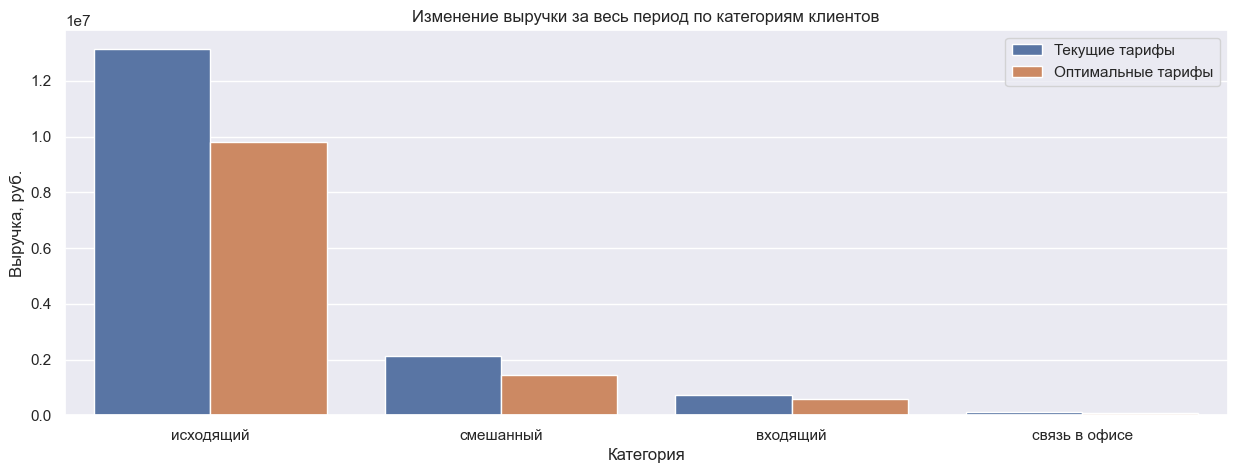

In [478]:
sns.barplot(total_revenue_categorys, 
            x=total_revenue_categorys['category'], 
            y=total_revenue_categorys['revenue'], 
            hue="current_best")

plt.title('Изменение выручки за весь период по категориям клиентов')
plt.xlabel('Категория')
plt.ylabel('Выручка, руб.')
plt.legend(title=None);

In [479]:
current = total_revenue_categorys.query('current_best =="Текущие тарифы"')['revenue'].sum()
best = total_revenue_categorys.query('current_best =="Оптимальные тарифы"')['revenue'].sum()
revenue_dinamic = round((current - best)/current*100,2)
print("Общее падение выручки при переходе всех клиентов на выгодные тарифы:",round(current - best),"(",revenue_dinamic, "%)")

Общее падение выручки при переходе всех клиентов на выгодные тарифы: 4188917 ( 26.0 %)


Сильнее всего снизится выручка с КЦ "смешанного типа" &mdash; на 32%. Меньше всего просядет выручка с клиентов, пользующихся услугами для связи в офисе (-16%). Общая выручка оператора сократится на 4 188 917 &#8381; (26%).

<a id='step_4_3_2'></a>
#### По месяцам

In [480]:
result_best=pd.DataFrame()
result_current=pd.DataFrame()
for user in offset.index:            
    users_best_t=offset.loc[user,'best']
    users_current=offset.loc[user,'current']
    payment_best = user_revenue(user, users_best_t)
    payment_current = user_revenue(user, users_current)
    result_best = pd.concat([result_best, payment_best], axis=0)
    result_best.loc[user,'category'] = offset.loc[user,'category']
    result_current = pd.concat([result_current, payment_current], axis=0)
    result_current.loc[user,'category'] = offset.loc[user,'category']
result_best = result_best.reset_index()
result_best.columns = ['user_id','Сентябрь','Октябрь','Ноябрь','category']

result_current = result_current.reset_index()
result_current.columns = ['user_id','Сентябрь','Октябрь','Ноябрь','category']

In [481]:
month_revenue_best = result_best.groupby(by='category').sum()
month_revenue_current = result_current.groupby(by='category').sum()
month_revenue_current = month_revenue_current[['Сентябрь','Октябрь','Ноябрь']]
month_revenue_best = month_revenue_best[['Сентябрь','Октябрь','Ноябрь']]
month_revenue_best = month_revenue_best.T
month_revenue_current = month_revenue_current.T
display(month_revenue_best)
display(month_revenue_current)

category,входящий,исходящий,связь в офисе,смешанный
Сентябрь,41736.4,891816.0,17343.80,88001.4
Октябрь,77643.2,1552865.4,26625.75,379351.5
Ноябрь,109695.1,1755604.4,26747.50,507704.5


category,входящий,исходящий,связь в офисе,смешанный
Сентябрь,63476.5,1534876.9,20111.70,113353.65
Октябрь,110948.9,2841202.2,34276.65,662963.15
Ноябрь,174798.8,3191809.3,33556.45,882677.60


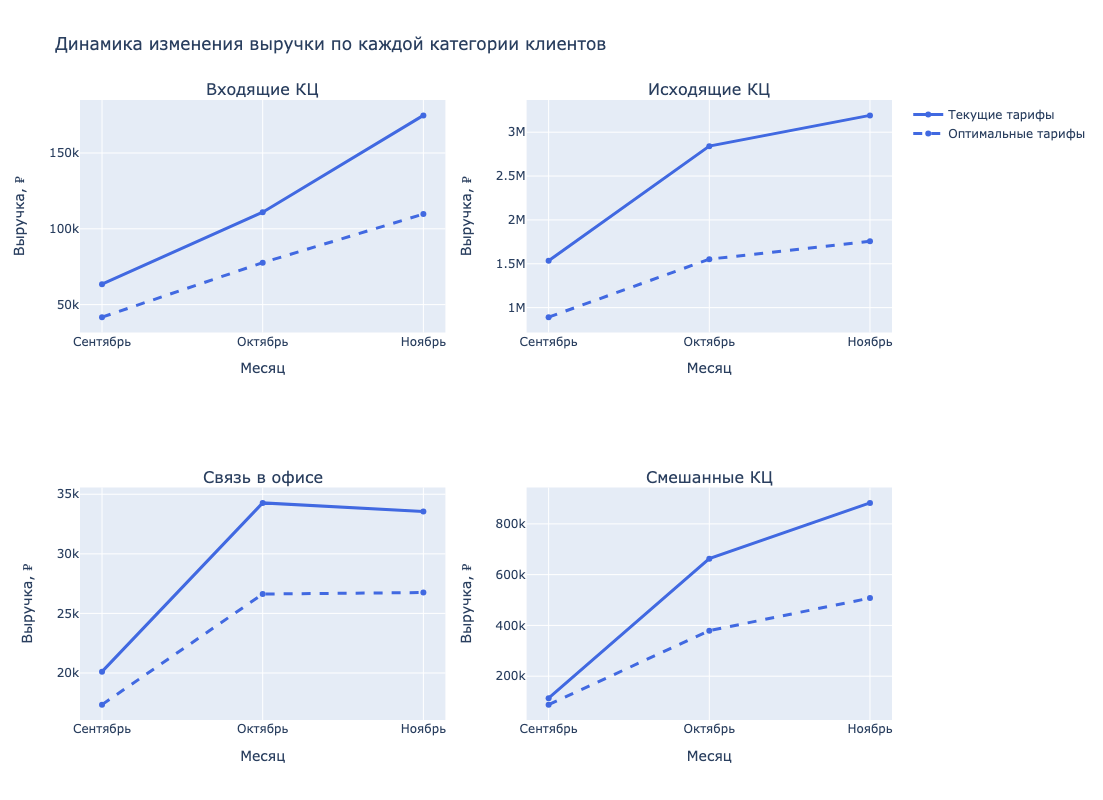

In [482]:
fig = make_subplots(rows=2, cols=2, 
                    subplot_titles=("Входящие КЦ", "Исходящие КЦ", "Связь в офисе", "Смешанные КЦ"))


fig.append_trace(go.Scatter(x=month_revenue_current.index, 
                            y=month_revenue_current['входящий'], 
                            name='Текущие тарифы',
                            line=dict(color='royalblue', width=3)), 
                 row=1, col=1)
fig.append_trace(go.Scatter(x=month_revenue_current.index, 
                            y=month_revenue_best['входящий'], 
                            name='Оптимальные тарифы',
                            line=dict(color='royalblue', width=3, dash='dash')), 
                 row=1, col=1)

fig.append_trace(go.Scatter(x=month_revenue_current.index, 
                            y=month_revenue_current['исходящий'], 
                            name='Текущие тарифы',
                            line=dict(color='royalblue', width=3),
                            showlegend=False), 
                 row=1, col=2)
fig.append_trace(go.Scatter(x=month_revenue_best.index, 
                            y=month_revenue_best['исходящий'], 
                            name='Оптимальные тарифы',
                            line=dict(color='royalblue', width=3, dash='dash'),
                            showlegend=False), 
                 row=1, col=2)

fig.append_trace(go.Scatter(x=month_revenue_current.index, 
                            y=month_revenue_current['связь в офисе'], 
                            name='Текущие тарифы',
                            line=dict(color='royalblue', width=3),
                            showlegend=False), 
                 row=2, col=1)
fig.append_trace(go.Scatter(x=month_revenue_best.index, 
                            y=month_revenue_best['связь в офисе'], 
                            name='Оптимальные тарифы',
                            line=dict(color='royalblue', width=3, dash='dash'),
                            showlegend=False), 
                 row=2, col=1)

fig.append_trace(go.Scatter(x=month_revenue_current.index, 
                            y=month_revenue_current['смешанный'], 
                            name='Текущие тарифы',
                            line=dict(color='royalblue', width=3),
                            showlegend=False),
                 row=2, col=2)
fig.append_trace(go.Scatter(x=month_revenue_best.index, 
                            y=month_revenue_best['смешанный'], 
                            name='Оптимальные тарифы',
                            line=dict(color='royalblue', width=3, dash='dash'),
                            showlegend=False), 
                 row=2, col=2)

fig.update_layout(
    height=800, 
    width=1000, 
    title_text="Динамика изменения выручки по каждой категории клиентов", 
    xaxis1_title = 'Месяц',
    yaxis1_title = 'Выручка, ₽',
    xaxis2_title = 'Месяц',
    yaxis2_title = 'Выручка, ₽',
    xaxis3_title = 'Месяц',
    yaxis3_title = 'Выручка, ₽',
    xaxis4_title = 'Месяц',
    yaxis4_title = 'Выручка, ₽',
    legend_tracegroupgap = 10
)
fig.show()


Графики выручки по месяцам, при условии, что все клиенты перейдут на оптимальные тарифы, во многом похожи на действительные графики выручки по месяцам, только отложенные со смещением вниз. Можно заметить, что рост гипотетической прибыли не такой быстрый. Среди смешанных КЦ гипотетическая выручка приближена к реальной, но в следующем месяце графики уже сильно расходятся. На графике, иллюстрирующем выручку с клиентов категории "Связь в офисе", можно заметить небольшое падение реальной выручки в ноябре, а гипотетическая выручка при этом осталась неизменной.

<a id='step_4_3_3'></a>
#### На одного клиента

Для исследования изменения выручки на одного клиента построим диаграммы размаха для средних чеков для клиентов до смены тарифа и после смены на самый оптимальный вариант.

In [483]:
avg_month_current_best = pd.DataFrame()

for user in active_clients:
    current_t = active_users_all_tariffs_avg_month.loc[user,'current']
    best_t = active_users_all_tariffs_avg_month.loc[user,'best']
    avg_month_current_best.loc[user,'current'] = active_users_all_tariffs_avg_month.loc[user,current_t] 
    avg_month_current_best.loc[user,'best'] = active_users_all_tariffs_avg_month.loc[user,best_t]
    
avg_month_current_best    

,current,best
166377,52721.00,34259.27
166391,1200.00,1200.00
166392,1600.00,1600.00
166405,154014.73,94907.17
166406,47337.37,31113.00
...,...,...
168583,2225.00,1450.00
168598,1300.00,1300.00
168601,24834.40,14057.60
168603,2743.50,2130.90


In [484]:
avg_month_current_best = avg_month_current_best.stack().to_frame('revenue').reset_index()
avg_month_current_best.rename(columns={'level_1':'current_best'},inplace=True)
avg_month_current_best =  avg_month_current_best.sort_values(by='revenue', ascending=False)
avg_month_current_best['current_best'] = avg_month_current_best['current_best'].replace({'current':'Текущие тарифы',
                                                                                           'best':'Оптимальные тарифы'})

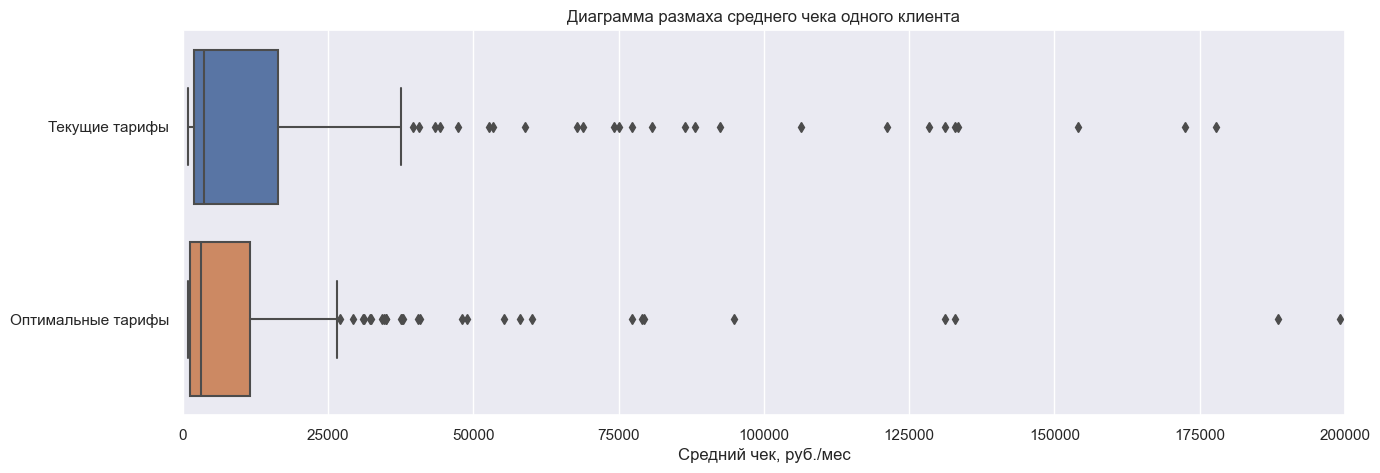

In [485]:
fig = sns.boxplot(avg_month_current_best, x ='revenue', y='current_best' )
fig.set_title('Диаграмма размаха среднего чека одного клиента')
fig.set_xlabel('Средний чек, руб./мес')
sns.set_theme(rc={'figure.figsize':(15,3)})
plt.ylabel('')
plt.xlim(0,200000);

Хорошо заметно, как сузились границы нормального распределения среднего чека клиентов на оптимальных тарифах: с 1000 и 37 500 &#8381;/мес до 1000 и 26 500 &#8381;/мес. Также значительно снизилось количество выбросов и уменьшилось медианное значение среднего чека: с 3660 &#8381;/мес до 3100 &#8381;/мес. 

<a id='step_4_4'></a>
### Распределение тарифов внутри категорий до и после перехода на более выгодные варианты

Проверим, как изменится распределение тарифов внутри категорий при переходе на более выгодные:

In [486]:
total_revenue_tariffs = total_revenue.reset_index()
total_revenue_tariffs_current = total_revenue_tariffs.pivot_table(index='category',columns='current_tp', 
                                                          values='index', 
                                                          aggfunc = 'count')
total_revenue_tariffs_current['sum']=total_revenue_tariffs_current.sum(axis=1)
total_revenue_tariffs_current = total_revenue_tariffs_current.sort_values(by='sum', ascending=False)
total_revenue_tariffs_current = total_revenue_tariffs_current.drop('sum', axis=1)
total_revenue_tariffs_best = total_revenue_tariffs.pivot_table(index='category',columns='best_tp', 
                                                          values='index', 
                                                          aggfunc = 'count')
total_revenue_tariffs_best['sum']=total_revenue_tariffs_best.sum(axis=1)
total_revenue_tariffs_best = total_revenue_tariffs_best.sort_values(by='sum', ascending=False)
total_revenue_tariffs_best = total_revenue_tariffs_best.drop('sum', axis=1)


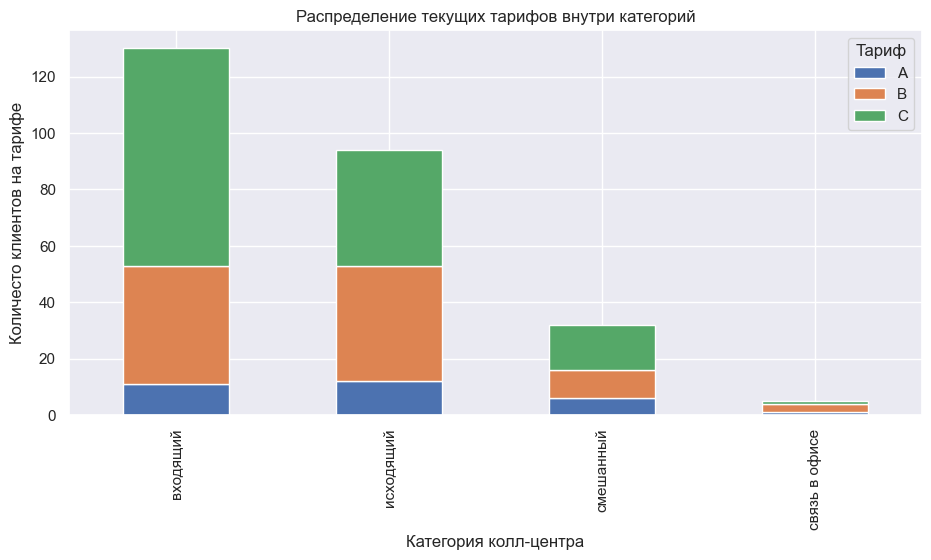

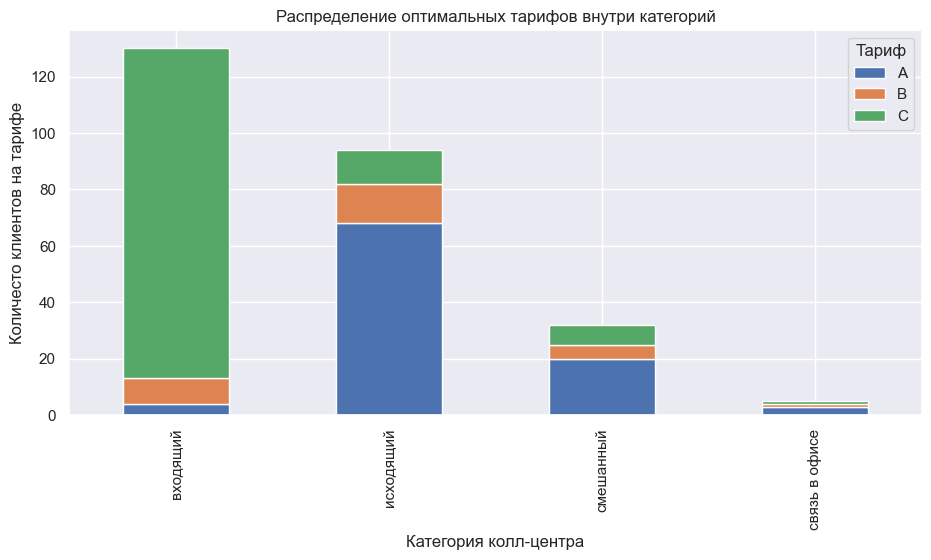

In [487]:
total_revenue_tariffs_current.plot.bar(stacked=True, figsize=(11,5))
plt.title('Распределение текущих тарифов внутри категорий')
plt.xlabel('Категория колл-центра')
plt.ylabel('Количесто клиентов на тарифе')
plt.legend(title='Тариф')
plt.show()

total_revenue_tariffs_best.plot.bar(stacked=True, figsize=(11,5))
plt.title('Распределение оптимальных тарифов внутри категорий')
plt.xlabel('Категория колл-центра')
plt.ylabel('Количесто клиентов на тарифе')
plt.legend(title='Тариф')
plt.show()

Для КЦ, относящихся к категории "исходящие" и "смешанные", часто лучше всего подходит тариф А: так как на этом тарифе самая низкая стоимость минут на исходящие звонки вне сети и внутри сети сверх пакета, а также самая маленькая стоимость обслуживания одного оператора. Клиентам, обрабатывающим входящие звонки, лучше всего подойдёт тариф С: так как входящие звонки бесплатны и не имеет смысла переплачивать за пакет минут внутри сети, который не будет использоваться. Однако если операторы много созваниваются между собой, то можно рассмотреть тарифы B и А, в зависимости от количества операторов в контакт-центре. Для связи в офисе подойдёт тот тариф из линейки, который лучше всего соотносится с его размером: крупным офисам рекомендуется тариф A, мелким &mdash; тариф С.

<a id='step_4_5'></a>
### Как уменьшить риск падения выручки, если все клиенты перейдут на более выгодные тарифы

1. Рекомендую доработать систему мониторинга, которая будет пресекать использование одного аккаунта несколькими физическими операторами: количество минут, потраченных на обработку вызовов, останется тем же, а за операторов клиент должен будет заплатить. 
2. Также рекомендуется доработать отслеживание активности оператора контакт-центра, и при фиксации времени на линии, превышающем рабочее время, блокировать доступ в систему. Это оградит абонентов от исбыточных списаний (повысится лояльность) и защитит операторов от незаконных переработок.
3. Предложить "пакетные" решения для каждого типа клиентов и сделать на этом акцент в рекламных кампаниях: клиенту не придётся самостоятельно прикидывать свои траты на каждом тарифе и он сможет быстрее принять решение о сотрудничестве.
4. Поддерживать обратную связь с клиентами: многие клиенты перестают пользоваться услугами оператора в течение первого месяца. Новые пользователи обычно нуждаются в повышенном внимании, не всегда клиенты могут быстро разобраться в интерфейсе системы и правильно подсчитать предполагаемую плату по тарифу.

<a id='step_4_6'></a>
### Выводы

<ol>
    <li>Для каждого клиента были рассчитаны средний чек и общие траты на связь за весь актуальный период.</li>
<li>Рассчитан гипотетический средний чек для каждого пользователя на каждом из тарифов линейки. По этой таблице определелили самый выгодный тариф для каждого пользователя и решили предлагать переход, если разница в среднем чеке на текущем тарифе и на лучшем предложении составляет более 10%. В результате можем предложить переход 135 пользователям.</li>
<li>Исследовано распределение клиентов по текущим тарифам и по оптимальным: в обоих случаях самым популярным тарифом остаётся тариф С, а доли пользователей на тарифах А и B поменяются.</li>  
<li>При переходе клиентов на более оптимальные тарифы выручка "Нупозвони" снизится для каждой из категорий. Больше всего будут экономить клиенты категории "исходящие КЦ" и "смешанные КЦ".</li> 
<li>Исследована динамика изменения выручки с каждой категории клиентов по месяцам, составлены графики изменения выручки. Можно заметить, что рост гипотетической прибыли не такой быстрый. Среди смешанных КЦ гипотетическая выручка приближена к реальной, но в следующем месяце графики уже сильно расходятся. На графике, иллюстрирующем выручку с клиентов категории "Связь в офисе" можно заметить небольшое падение реальной выручки в ноябре, а гипотетическая выручка при этом осталась неизменной.</li>
<li>Изучено изменение среднего чека на одного пользователя: при переходе на более выгодные тарифы заметно сузились границы нормального распределения среднего чека клиентов: с 1000 и 37 500 &#8381;/мес до 1000 и 26 500 &#8381;/мес. Также значительно снизилось количество выбросов и уменьшилось медианное значение среднего чека: с 3660 &#8381;/мес до 3100 &#8381;/мес.</li>
<li>Рассмотрено распределение тарифов внутри категорий клиентов до и после перехода на оптимальные варианты: для КЦ, относящихся к категории "исходящие" и "смешанные", часто лучше всего подходит тариф А, так как на этом тарифе самая низкая стоимость минут на исходящие звонки вне сети и внутри сети сверх пакета, а также самая маленькая стоимость обслуживания одного оператора. Клиентам, обрабатывающим входящие звонки, лучше всего подойдёт тариф С: так как входящие звонки бесплатны, не имеет смысла переплачивать за пакет минут внутри сети, который не будет использоваться. Однако если операторы много созваниваются между собой, то можно рассмотреть тарифы B и А в зависимости от количества операторов в контакт-центре. Для связи в офисе подойдёт тот тариф из линейки, который лучше всего соотносится с его размером: крупным офисам рекомендуется тариф A, мелким &mdash; тариф С.</li>
<li>Даны <a href='#step_4_5'>рекомендации</a> по уменьшению риска падения выручки при переходе всех клиентов на более выгодные тарифы.</li>

<a id='step_5'></a>
## Проверка статистических гипотез

<a id='step_5_1'></a>
### Гипотеза 1: Среднемесячные чеки активных клиентов на тарифе А выше, чем среднемесячные чеки активных клиентов на тарифе B

$H_0$: Среднемесячные чеки активных клиентов на тарифах A и B равны.  
$H_1$: Среднемесячные чеки активных клиентов на тарифе А выше, чем среднемесячные чеки активных клиентов на тарифе B.

Так как в данных есть выбросы, которые могут существенно повлиять на результат, гипотеза будет проверена с помощью непараметрического теста Уилкоксона-Манна-Уитни:

In [488]:
current_revenue_A = []
current_revenue_B = []
for user in active['user_id'].unique():
    if define_tariff(user) == "A":
        revenue = user_revenue(user, "A").dropna().values.tolist()
        current_revenue_A.extend(revenue)
    elif define_tariff(user) == "B":
        revenue = user_revenue(user, "B").dropna().values.tolist()
        current_revenue_B.extend(revenue)    
        
    
current_revenue_A = list(itertools.chain(*current_revenue_A))
current_revenue_B = list(itertools.chain(*current_revenue_B))

In [489]:
alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(current_revenue_A, current_revenue_B, True, 'greater')

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.02650080203262023
Отвергаем нулевую гипотезу: разница статистически значима


Отвергаем гипотезу в пользу альтернативной: среднемесячные чеки активных клиентов на тарифе A выше, чем среднемесячные чеки активных клиентов на тарифе B. 

<a id='step_5_2'></a>
### Гипотеза 2: среднемесячный перерасход минут активных клиентов на тарифе А равен среднемесячному перерасходу минут активных клиентов на тарифе B 



$H_0$: Среднемесячный перерасход минут на исходящие внутренние вызовы активных клиентов на тарифе A равен среднемесячному перерасходу минут активных клиентов на тарифе B.  
$H_1$: Среднемесячный перерасход минут активных клиентов на тарифе A отличается от среднемесячного перерасхода минут активных клиентов на тарифе B.  

Гипотеза будет проверена с помощью непараметрического теста Уилкоксона-Манна-Уитни:

In [490]:
minutes_overspend_A = []
minutes_overspend_B = []

for user in active['user_id'].unique():
    tariff_plan = clients.loc[user,'tariff_plan']
    user_statistics = active.query('user_id==@user and direction=="out" & internal==True') 
    outbounds_internal_mins = user_statistics.pivot_table(index='user_id', 
                                                          columns='month', 
                                                          values = 'total_call_duration', 
                                                          aggfunc='sum', 
                                                          fill_value=0)
    if outbounds_internal_mins.empty: outbounds_internal_payment = [0]
    else:
        min_limit = tariffs.loc[tariff_plan,'outgoing_internal_minutes_limit']
        outbounds_internal_payment = internal_limits_check(outbounds_internal_mins.loc[user], min_limit).tolist() 
    if define_tariff(user) == "A":  
        minutes_overspend_A.extend(outbounds_internal_payment)
    elif define_tariff(user) == "B":  
        minutes_overspend_B.extend(outbounds_internal_payment)    



In [491]:
results = st.mannwhitneyu(minutes_overspend_A, minutes_overspend_B)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.03562549464754247
Отвергаем нулевую гипотезу: разница статистически значима


Отвергаем нулевую гипотезу в пользу альтернативной: средний перерасход минут на внутренние исходящие вызовы на тарифах A и B различается.

<a id='step_6'></a>
## Выводы

**Подготовка данных к анализу**:
1. В датафрейме с агрегированными данными о звонках обнаружен высокий процент строк-дубликатов (~9 %). Отделу, подготовившему выгрузку, рекомендовано перепроверить алгоритм выгрузки данных.
2. В столбцах internal и operator_id найдено небольшое количество пропущенных значений, большая часть из них — пропущенные входящие вызовы. Так как пропусков малое количество и восстановлению они не подлежат, их удалили из датафрейма.
3. Также обнаружено большое количество аномально долгих звонков (которые длились больше суток), большая их часть произошла в октябре и ноябре 2019 года. Рекомендуется перепроверить данные мониторинга оператора связи на наличие сбоев в работе оборудования и связаться с контактным центром для уточнения деталей.
4. Также обнаружены клиенты, которых можно заподозрить в сокрытии реального количества операторов: 166406, 166533, 166582, 167112, 167285, 167626, 167645, 167650, 167827, 168018, 168025, 168064, 168093, 168361. Рекомендуется службе безопасности операторов перепроверить клиентов с этими идентификаторами.
5. В датафрейме о клиентах не было обнаружено пропущенных и аномальных значений. Договоры заключались с 1 августа по 31 октября 2019 года, всего в базе 732 клиента.

**Исследовательский анализ данных**: 
1. Исследуемый период: с 1 сентября по 30 ноября 2019 года.
2. Критерий неактивности клиента: клиент не пользовался услугами оператора в течение последнего месяца. В список активных клиентов попал 261 клиент. За время исследуемого периода 14 % от всех клиентов, пользовавшихся услугами оператора связи, стали неактивными.
3. Большая часть клиентов перестала пользоваться услугами в октябре 2019 года, при этом в октябре и ноябре было зафиксировано много аномально долгих вызовов. Возможно, причиной прекращения сотрудничества стали слишком большие ошибочно выставленные счета за услуги.
4. Большинство клиентов специализируется на обработке входящих вызовов — почти 50 % из всех активных КЦ. 36 % клиентов занимается обзвоном пользователей, 12,3 % обрабатывают и те и другие вызовы, и лишь 2 % пользуются услугами оператора для созвонов внутри сети.

**Подсчёт выручки для активных клиентов**:
1. Для каждого клиента были рассчитаны средний чек и общие траты на связь за весь актуальный период.
2. Для каждого пользователя на каждом из тарифов линейки был рассчитан гипотетический средний чек. На основе этой таблицы определили самый выгодный тариф для каждого пользователя. Предложение о переходе на другой тариф отправляли, если разница в среднем чеке на текущем тарифе и на лучшем составляла более 10 %. В результате переход смогли предложить 135 пользователям.
3. Исследовали распределение клиентов по текущим тарифам и по оптимальным. Самым популярным тарифом в обоих случаях остался тариф С. При этом доли пользователей на тарифах А и B поменяются.
4. Если клиенты перейдут на более оптимальные тарифы, выручка компании "Нупозвони" снизится для каждой из категорий. Больше всего будут экономить клиенты категории "исходящие КЦ" и "смешанные КЦ".
5. Изучена динамика изменения выручки с каждой категории клиентов по месяцам — построены графики изменения выручки.
6. Рост гипотетической прибыли не такой быстрый. Среди смешанных КЦ гипотетическая выручка приближена к реальной, но в следующем месяце графики уже сильно расходятся. На графике, иллюстрирующем выручку с клиентов категории "Связь в офисе", можно заметить небольшое падение реальной выручки в ноябре, а гипотетическая выручка при этом осталась неизменной.
7. Изучено изменение среднего чека на одного пользователя. При переходе на более выгодные тарифы границы нормального распределения среднего чека клиентов сузились с 1000 и 37 500 &#8381;/мес до 1000 и 26 500 &#8381;/мес. Также значительно снизилось количество выбросов и уменьшилось медианное значение среднего чека: с 3660 &#8381;/мес до 3100 &#8381;/мес.
8. Даны <a href='#step_4_5'>рекомендации</a> по уменьшению риска падения выручки при переходе всех клиентов на более выгодные тарифы.

Также были проверены две статистические гипотезы с помощью непараметрического теста Уилкоксона-Манна-Уитни: первую гипотезу о равенстве средних чеков тарифов А и B отвергли в пользу альтернативной &mdash; среднемесячные чеки активных клиентов на тарифе A выше, чем среднемесячные чеки активных клиентов на тарифе B. Вторую гипотезу о равенстве среднемесячных перерасходов минут активных клиентов на тарифах А и B также отвергли в пользу альтернативной.